**做了四個方法**


1.羅吉斯+PCA+加權(1:10) 80%

2.羅吉斯+PCA+SMOTE 80%

3.羅吉斯+PCA+加權(1:10) 90%

4.羅吉斯+PCA+SMOTE 90%

羅吉斯是直接讓模型跑，PCA有80%跟90%，有處理不平衡的表現比沒有的好很多，但仍存在FP跟FN。最好模型羅吉斯 + PCA(90%) + 加權 (1:10)

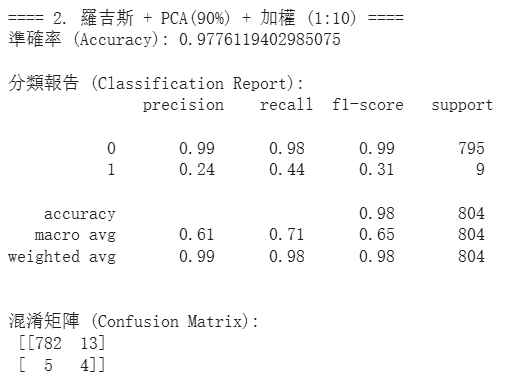

###套件載入

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

###資料載入

In [15]:
file_path = "/content/drive/MyDrive/filled_data_label_numeric.xlsx"
filled_data_label_numeric_df = pd.read_excel(file_path,engine='openpyxl')

In [16]:
# 目標欄位
target_col = "abnormal_target"

# 特徵與目標
X = filled_data_label_numeric_df.drop(columns=[target_col])
y = filled_data_label_numeric_df[target_col]

# 特徵標準化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 做 PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# 計算累積解釋變異量
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# 找出保留 80% 和 90% 變異量所需主成分數量
n_pc_80 = next(i+1 for i, var in enumerate(cumulative_variance) if var >= 0.80)
n_pc_90 = next(i+1 for i, var in enumerate(cumulative_variance) if var >= 0.90)

print(f"保留80%變異量需要主成分數量: {n_pc_80}")
print(f"保留90%變異量需要主成分數量: {n_pc_90}")

# 取前 n_pc_80 和 n_pc_90 主成分
X_pca_80 = X_pca[:, :n_pc_80]
X_pca_90 = X_pca[:, :n_pc_90]

保留80%變異量需要主成分數量: 34
保留90%變異量需要主成分數量: 45


###PCA前的羅吉斯回歸

##PCA後的動作

###純PCA+羅吉斯

####
羅吉斯 + PCA(80%) + 加權 (1:10)

羅吉斯 + PCA(90%) + 加權 (1:10)

羅吉斯 + PCA(80%) + SMOTE

羅吉斯 + PCA(90%) + SMOTE

In [19]:
# -------------------------------
# 定義函數：訓練 + 評估模型
def train_eval_logistic(X, y, use_smote=False, class_weight=None):
    # 分割資料集
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # 若使用 SMOTE 做過採樣
    if use_smote:
        sm = SMOTE(random_state=42)
        X_train, y_train = sm.fit_resample(X_train, y_train)

    # 建立羅吉斯回歸模型
    log_model = LogisticRegression(max_iter=1000, class_weight=class_weight)
    log_model.fit(X_train, y_train)

    # 預測
    y_pred = log_model.predict(X_test)

    # 評估
    print("準確率 (Accuracy):", accuracy_score(y_test, y_pred))
    print("\n分類報告 (Classification Report):\n", classification_report(y_test, y_pred))
    print("\n混淆矩陣 (Confusion Matrix):\n", confusion_matrix(y_test, y_pred))
    print("-" * 50)

    return log_model, X_test, y_test

# -------------------------------
print("==== 1. 羅吉斯 + PCA(80%) + 加權 (1:10) ====")
train_eval_logistic(X_pca_80, y, use_smote=False, class_weight={0:1, 1:10})

print("==== 2. 羅吉斯 + PCA(90%) + 加權 (1:10) ====")
train_eval_logistic(X_pca_90, y, use_smote=False, class_weight={0:1, 1:10})

print("==== 3. 羅吉斯 + PCA(80%) + SMOTE ====")
train_eval_logistic(X_pca_80, y, use_smote=True, class_weight=None)

print("==== 4. 羅吉斯 + PCA(90%) + SMOTE ====")
train_eval_logistic(X_pca_90, y, use_smote=True, class_weight=None)

==== 1. 羅吉斯 + PCA(80%) + 加權 (1:10) ====
準確率 (Accuracy): 0.9701492537313433

分類報告 (Classification Report):
               precision    recall  f1-score   support

           0       0.99      0.98      0.98       795
           1       0.11      0.22      0.14         9

    accuracy                           0.97       804
   macro avg       0.55      0.60      0.56       804
weighted avg       0.98      0.97      0.98       804


混淆矩陣 (Confusion Matrix):
 [[778  17]
 [  7   2]]
--------------------------------------------------
==== 2. 羅吉斯 + PCA(90%) + 加權 (1:10) ====
準確率 (Accuracy): 0.9776119402985075

分類報告 (Classification Report):
               precision    recall  f1-score   support

           0       0.99      0.98      0.99       795
           1       0.24      0.44      0.31         9

    accuracy                           0.98       804
   macro avg       0.61      0.71      0.65       804
weighted avg       0.99      0.98      0.98       804


混淆矩陣 (Confusion Matrix):
 [[78

(LogisticRegression(max_iter=1000),
 array([[ 2.11148659e+00,  4.52897273e-01,  2.72901132e-01, ...,
         -4.54192600e-01,  2.14991740e-01,  2.83627665e-01],
        [ 2.77489131e+00,  7.59635801e-01, -3.43880426e-01, ...,
          5.38211079e-01, -1.34759986e-01,  4.77590623e-02],
        [-4.41561816e+00, -2.92439322e+00, -2.62537945e+00, ...,
         -7.85573533e-02,  1.13189669e+00, -1.06431008e-01],
        ...,
        [-4.43316900e+00, -2.10478754e+00,  2.00259933e+00, ...,
          8.26208785e-01,  2.04795097e-03, -1.38807421e+00],
        [ 1.74904147e+00, -1.04770004e+00, -3.52151052e-01, ...,
          6.74052892e-01,  2.43044116e-02, -3.46716796e-01],
        [ 1.28686537e+00,  2.52240609e+00,  1.44944069e+00, ...,
          9.23565504e-03,  3.46617145e-01,  2.25952845e-01]]),
 2295    0
 1204    0
 3644    0
 1953    0
 1226    0
        ..
 2776    0
 3572    0
 1929    0
 3749    0
 3878    0
 Name: abnormal_target, Length: 804, dtype: int64)